## Two Step Method to Remove Projective and Affine Distortion
Tejas Pant <br>
17th September, 2018

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os

os.listdir('../HW3Pics/')
images = glob.glob('../HW3Pics/*.jpg')

selectImage = 1 #1 = 11.jpg, 2 = 2.jpg
selectProjDistMethod = 1 #1 = point to point correspondence, 2 = Vanishing Line
RemoveAffineDist = 1 #0 = No, 1 = Yes
image = mpimg.imread(images[selectImage-1])
image_org = np.copy(image)
image_shape = image.shape

(1944, 2592, 3)


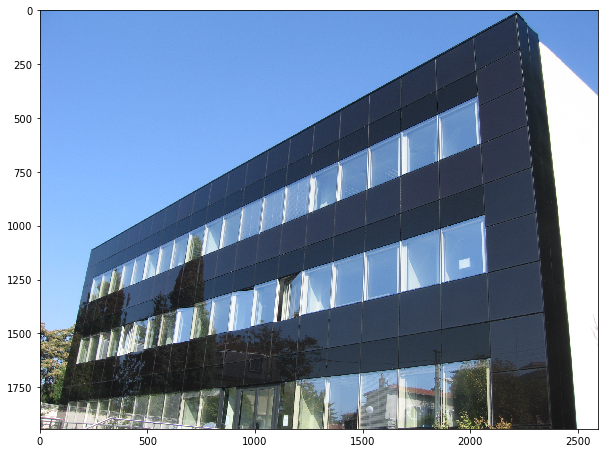

In [18]:
print(image.shape)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [19]:
#Selection of points for Each Image

if selectImage == 1:
    ################################
    #For point-to-point correspondence
    # Image coordinates
    P = [1126, 987]
    Q = [1241, 945]
    S = [1254, 765]
    R = [1142, 813]
        
    # World coordinates
    P_ = [0,80]
    Q_ = [60, 80]
    S_ = [60, 0]
    R_ = [0, 0]
    ###############################
    
    ################################
    #For vanishing line method
    #First Set of parallel lines
    P1_VL = [224, 1352]
    Q1_VL = [2046, 618]
    S1_VL = [2032, 396]
    R1_VL = [249, 1243]
    ################################

    '''
    ###############################
    #For vanishing line method
    #Second Set of parallel lines
    P1_VL = [132, 1809]
    Q1_VL = [2090, 1612]
    S1_VL = [2033, 394]
    R1_VL = [246, 1245]
    ################################
    '''
    
    ################################
    #For removing affine
    P1_AF = [1272, 526]
    Q1_AF = [2210, 10]
    R1_AF = [2335, 1397]
    S1_AF = [1192, 1589]
    ################################
        
elif selectImage == 2:
    ################################
    #For point-to-point correspondence
    P = [236, 280]
    Q = [334, 274]
    R = [238, 57]
    S = [335, 73]
        
    # World coordinates
    P_ = [0,80]
    Q_ = [40, 80]
    R_ = [0, 0]
    S_ = [40, 0]
    ###############################
    
    '''
    ################################
    #For vanishing line method
    #First Set of parallel lines
    P1_VL = [240, 279]
    Q1_VL = [333, 272]
    S1_VL = [334, 74]
    R1_VL = [239, 59]
    ################################
    '''
    
    ################################
    #For vanishing line method
    #Second Set of parallel lines
    P1_VL = [46, 245]
    Q1_VL = [138, 241]
    S1_VL = [137, 127]
    R1_VL = [49, 121]
    ################################
    
    ################################
    #For removing affine
    P1_AF = [240, 63]
    Q1_AF = [333, 76]
    R1_AF = [332, 169]
    S1_AF = [240, 168]
    ################################

In [20]:
#Calculate Homography Based on Point to Point Correspondence
def calcHomographyPointCorrespond(P,Q,R,S,P_,Q_,R_,S_):
    '''
    Points should be selected in this way
    R-----------S
    |           |
    |           |
    |           | 
    |           |
    P-----------Q
    Origin is at P
    '''   
    
    X = P + Q + R + S 
    X_prime = P_ + Q_ + R_ + S_ 

    A = np.zeros((8,8))
    H = np.ones((3,3))

    for i in range(4):
        H_rowx = [0 for i in range(8)]
        H_rowy = [0 for i in range(8)]

        H_rowx[0] = X[2*i]
        H_rowx[1] = X[2*i+1]
        H_rowx[2] = 1
        H_rowx[6] = -X[2*i]*X_prime[2*i]
        H_rowx[7] = -X[2*i+1]*X_prime[2*i]

        H_rowy[3] = X[2*i]
        H_rowy[4] = X[2*i+1]
        H_rowy[5] = 1
        H_rowy[6] = -X[2*i]*X_prime[2*i+1]
        H_rowy[7] = -X[2*i+1]*X_prime[2*i+1]

        A[2*i] = H_rowx
        A[2*i+1] = H_rowy

    param = np.matmul(np.linalg.inv(A),np.array(X_prime))
    
    param = np.append(param,1)
    for i in range(3):
        H[i] = param[3*i:3*i+3]
    return H

#Calculate Homography Based on Vanishing Line Method
def calcHomographyVanishLine(P1,Q1,R1,S1):
    '''
    Points should be selected in this way
    R-----------S
    |           |
    |           |
    |           | 
    |           |
    P-----------Q
    ''' 
    #Get Homogeneous representation of physical co-ordinates
    P1 = np.append(P1,1)
    Q1 = np.append(Q1,1)
    R1 = np.append(R1,1)
    S1 = np.append(S1,1)
    
    #Lines for determing Vanishing point 1
    LineP1Q1 = np.cross(P1,Q1) 
    LineS1R1 = np.cross(S1,R1)
    
    #Vanishing point 1
    VP1 = np.cross(LineP1Q1,LineS1R1)
    #Normalize Vanishing Point 1
    VP1 = VP1/VP1[-1]

    #Lines for determing Vanishing point 2
    LineP2Q2 = np.cross(Q1,S1)  
    LineS2R2 = np.cross(R1,P1)
    
    #Vanishing point 2
    VP2 = np.cross(LineP2Q2,LineS2R2)
    #Normalize Vanishing Point 2
    VP2 = VP2/VP2[-1]
    
    #Getting vanishing line from vanishing points
    VanishLine = np.cross(VP1,VP2)
    VanishLine = VanishLine/VanishLine[-1]
    
    #Setting up 3x3 Homography matrix
    H = np.identity(3)
    H[-1,:] = VanishLine
    return H

#Calculate Homography to Remove Affine Distortion
def calcHomographyAffine(P,Q,R,S):
    '''
    Points should be selected in this way
    P-----------Q
    |           |
    |           |
    |           | 
    |           |
    S-----------R
    '''     
    A = np.zeros((2,2))
    S_mat = np.ones((2,2))
    H = np.identity(3)
    
    #First pair of perpendicular lines
    l1 = np.cross(P,Q) #l'
    m1 = np.cross(Q,R) #m'
    
    #Second pair of perpendicular lines
    l2 = np.cross(R,P)
    m2 = np.cross(S,Q)
    
    A[0,:] = [l1[0]*m1[0], l1[0]*m1[1] + l1[1]*m1[0]]
    A[1,:] = [l2[0]*m2[0], l2[0]*m2[1] + l2[1]*m2[0]]
    
    B = np.array([-l1[1]*m1[1], -l2[1]*m2[1]])
    
    S_elem = np.matmul(np.linalg.pinv(A),B)
    S_mat[0,:] = [S_elem[0], S_elem[1]]
    S_mat[1,0] = S_elem[1]
    
    U, D, Vt = np.linalg.svd(S_mat, full_matrices=True)
    D_sq = np.zeros((2,2))
    D_sq[0,0] = np.sqrt(D[0])
    D_sq[1,1] = np.sqrt(D[1]) 
    
    A_forS = np.matmul(np.matmul(Vt,D_sq),np.transpose(Vt))
    
    H[0:2,0:2] = A_forS
    return H

#Get Undistorted Image Data like scale factor, Offset
def getUndisortedImgData(H_,image):
    
    #Convert four corners of distorted image into 
    #four corners of undistorted image in world co-ordinates
    
    image_corners = np.zeros((4,2))
    world_coord_corners = np.zeros((4,2))
    image_shape = image.shape

    #Four Corners of Distorted Image
    image_corner_LB = [0,0] #left bottom X, Y coordinates
    image_corner_LT = [0,image_shape[0]] #left top
    image_corner_RB = [image_shape[1],0] #right bottom
    image_corner_RT = [image_shape[1],image_shape[0]]
    
    image_corners[0] = image_corner_LB
    image_corners[1] = image_corner_LT
    image_corners[2] = image_corner_RB
    image_corners[3] = image_corner_RT
    
    #Get four corners of undistorted image in world co-ordinates
    for i in range(len(image_corners)):
        coord = image_corners[i]
        coord2 = np.append(coord,1)
        coord2 = np.matmul(H_,coord2)
        coord2 = coord2 / coord2[-1]
        world_coord_corners[i] = coord2[0:2]
        
    #Get corresponding coordinates in world coordinates
    print("Corners of Undistorted Image in World Co-ordinates = ", world_coord_corners)
    
    #The undistorted image will have some offset and will have to scaled
    
    #Get Offset
    offsetX = np.round(np.min(world_coord_corners[:,0]))
    offsetY = np.round(np.min(world_coord_corners[:,1]))
    
    #Scaling in X direction
    scaleFactorX = image_shape[1] / (np.max(world_coord_corners[:,0]) - np.min(world_coord_corners[:,0])) 
    
    #Scaling in Y direction
    scaleFactorY = image_shape[0] / (np.max(world_coord_corners[:,1]) - np.min(world_coord_corners[:,1]))
    
    #Using only one scaling factor for both X, Y directions
    if (scaleFactorX > scaleFactorY):
        scaleFactor = scaleFactorX
    else:
        scaleFactor = scaleFactorY
        
    #Get shape of new world image
    world_image_Xdim = np.round((np.max(world_coord_corners[:,0]) - np.min(world_coord_corners[:,0]))*scaleFactor)
    world_image_Ydim = np.round((np.max(world_coord_corners[:,1]) - np.min(world_coord_corners[:,1]))*scaleFactor)
        
    #Initialize world image to black color
    world_image = np.zeros((int(world_image_Ydim), int(world_image_Xdim), 3),dtype='uint8')
        
    print("Actual image shape = ", image_shape)
    print("Undistorted Image Shape = ", world_image.shape)
        
    return offsetX, offsetY, scaleFactor, world_image

#Get the image once the undistorted image parameters are obtained
def getImage(offsetX, offsetY, scaleFactor, world_image,H_inv_):
    for i in range(0,world_image.shape[1]-1): #X-cooridnate, col
        for j in range(0,world_image.shape[0]-1): #Y-coordinate, row
            k1 = i/scaleFactor + offsetX
            k2 = j/scaleFactor + offsetY
            X_domain = [k1,k2]
            X_domain = np.array(X_domain)
            X_domain = np.append(X_domain,1)
            X_range = np.matmul(H_inv_, X_domain)
            X_range = X_range/X_range[-1]
            X_range = np.rint(X_range)
            X_range = X_range.astype(int)
            if(X_range[0] > 0 and X_range[1] > 0 and X_range[0] < image_shape[1] and X_range[1] < image_shape[0]):
                world_image[j][i] = image_org[X_range[1]][X_range[0]]
                
    return world_image

#Transform end points of the orthogonal lines used to remove affine transformation
def transformEndPointsPerpendLinesAffine(H_,image,P,Q,R,S):
    
    P = np.append(P,1)
    Q = np.append(Q,1)
    R = np.append(R,1)
    S = np.append(S,1)

    image_corners = np.zeros((4,2))
    world_coord_corners = np.zeros((4,2))
    image_shape = image.shape

    #Four Corners of Distorted Image
    image_corner_LB = [0,0] #left bottom X, Y coordinates
    image_corner_LT = [0,image_shape[0]] #left top
    image_corner_RB = [image_shape[1],0] #right bottom
    image_corner_RT = [image_shape[1],image_shape[0]]
    
    image_corners[0] = image_corner_LB
    image_corners[1] = image_corner_LT
    image_corners[2] = image_corner_RB
    image_corners[3] = image_corner_RT
    
    #Get four corners of undistorted image in world co-ordinates
    for i in range(len(image_corners)):
        coord = image_corners[i]
        coord2 = np.append(coord,1)
        coord2 = np.matmul(H_,coord2)
        coord2 = coord2 / coord2[-1]
        world_coord_corners[i] = coord2[0:2]
        
    #Get Offset
    offsetX = np.round(np.min(world_coord_corners[:,0]))
    offsetY = np.round(np.min(world_coord_corners[:,1]))
    
    #Scaling in X direction
    scaleFactorX = image_shape[1] / (np.max(world_coord_corners[:,0]) - np.min(world_coord_corners[:,0])) 
    
    #Scaling in Y direction
    scaleFactorY = image_shape[0] / (np.max(world_coord_corners[:,1]) - np.min(world_coord_corners[:,1]))
    
    #Need to use larger of the two scaling factors otherwise the other dimension will exceed the actual images dimensions
    if (scaleFactorX > scaleFactorY):
        scaleFactor = scaleFactorX
    else:
        scaleFactor = scaleFactorY
      
    P_o = np.matmul(H_,P)
    P_o = np.rint(P_o[0:2]/P_o[-1])*scaleFactor - [offsetX, offsetY]

    Q_o = np.matmul(H_,Q)
    Q_o = np.rint(Q_o[0:2]/Q_o[-1])*scaleFactor - [offsetX, offsetY]

    R_o = np.matmul(H_,R)
    R_o = np.rint(R_o[0:2]/R_o[-1])*scaleFactor - [offsetX, offsetY]

    S_o = np.matmul(H_,S)
    S_o = np.rint(S_o[0:2]/S_o[-1])*scaleFactor - [offsetX, offsetY]
    
    #Transformed end points of 
    P_o = np.append(P_o,1)
    Q_o = np.append(Q_o,1)
    R_o = np.append(R_o,1)
    S_o = np.append(S_o,1)
    
    H_a = calcHomographyAffine(P_o,Q_o,R_o,S_o)
    return H_a

In [21]:
if selectProjDistMethod == 1: #Point-to-Point Correspond
    Hp_ = calcHomographyPointCorrespond(P,Q,R,S,P_,Q_,R_,S_)
elif selectProjDistMethod == 2: #Vanishing Line
    Hp_ = calcHomographyVanishLine(P1_VL,Q1_VL,R1_VL,S1_VL)

if RemoveAffineDist == 0: 
    H_total_ = Hp_ 
    H_total_inv_ = np.linalg.inv(H_total_)
    
elif RemoveAffineDist == 1:
    #Transform end points of perpendicular lines by removing projective distortion
    Haf_ = transformEndPointsPerpendLinesAffine(Hp_,image,P1_AF,Q1_AF,R1_AF,S1_AF)
    Haf_inv_ = np.linalg.inv(Haf_)
    H_total_ = np.matmul(Haf_inv_,Hp_)
    H_total_inv_ = np.linalg.inv(H_total_)

#Print image in Pure World
offsetX, offsetY, scaleFactor, world_image = getUndisortedImgData(H_total_,image)
undistImage = getImage(offsetX, offsetY, scaleFactor, world_image, H_total_inv_)
plt.imsave('Result.jpg',undistImage)
print("Image has been written")

Corners of Undistorted Image in World Co-ordinates =  [[-3144.29479247 -2407.36018887]
 [-1000.97123992   418.54088908]
 [  636.73167038   -46.98920485]
 [  572.21398552   460.24780714]]
Actual image shape =  (1944, 2592, 3)
Undistorted Image Shape =  (1966, 2592, 3)
Image has been written
